# Continuous SIMP example

## Commented Program

What follows is a program spliced with comments.

In [1]:
using TopOpt

### Define the problem

In [2]:
E = 1.0 # Young’s modulus
v = 0.3 # Poisson’s ratio
f = 1.0 # downward force

problems = Any[
    PointLoadCantilever(Val{:Linear}, (60, 20, 20), (1.0, 1.0, 1.0), E, v, f),
    PointLoadCantilever(Val{:Linear}, (160, 40), (1.0, 1.0), E, v, f),
    HalfMBB(Val{:Linear}, (60, 20), (1.0, 1.0), E, v, f),
    LBeam(Val{:Linear}, Float64; force=f),
    TieBeam(Val{:Quadratic}, Float64),
]
problem_names = [
    "3d cantilever beam", "cantilever beam", "half MBB beam", "L-beam", "tie-beam"
]

i = 2
println(problem_names[i])
problem = problems[i]

cantilever beam


### Parameter settings

In [3]:
V = 0.5 # volume fraction
xmin = 0.001 # minimum density
rmin = 3.0

convcriteria = Nonconvex.KKTCriteria()
x0 = fill(V, TopOpt.getncells(problem))
penalty = TopOpt.PowerPenalty(1.0)
solver = FEASolver(Direct, problem; xmin=xmin, penalty=penalty)
comp = Compliance(solver)
filter = if problem isa TopOptProblems.TieBeam
    identity
else
    DensityFilter(solver; rmin=rmin)
end
obj = x -> comp(filter(PseudoDensities(x)))

#1 (generic function with 1 method)

Define volume constraint

In [4]:
volfrac = Volume(solver)
constr = x -> volfrac(filter(PseudoDensities(x))) - V
model = Model(obj)
addvar!(model, zeros(length(x0)), ones(length(x0)))
add_ineq_constraint!(model, constr)
alg = MMA87()

nsteps = 4
ps = range(1.0, 5.0; length=nsteps + 1)

1.0:1.0:5.0

exponentially decaying tolerance from 10^-2 to 10^-4

In [5]:
tols = exp10.(range(-2, -4; length=nsteps + 1))
x = x0
for j in 1:(nsteps + 1)
    global convcriteria
    p = ps[j]
    tol = tols[j]
    TopOpt.setpenalty!(solver, p)
    options = MMAOptions(; tol=Tolerance(; kkt=tol), maxiter=1000, convcriteria)
    res = optimize(model, alg, x; options)
    global x = res.minimizer
end

@show obj(x)
@show constr(x)

[ Info:   iter       obj      Δobj  violation  kkt_residual  
[ Info:      0   4.9e+02       Inf   0.0e+00   1.4e+00
[ Info:      1   4.0e+02   8.8e+01   0.0e+00   3.5e+01
[ Info:      2   3.4e+02   6.1e+01   0.0e+00   1.1e+01
[ Info:      3   3.2e+02   2.3e+01   0.0e+00   2.9e+00
[ Info:      4   3.1e+02   6.4e+00   0.0e+00   9.9e-01
[ Info:      5   3.1e+02   2.3e+00   0.0e+00   4.3e-01
[ Info:      6   3.1e+02   1.1e+00   0.0e+00   2.1e-01
[ Info:      7   3.1e+02   5.7e-01   0.0e+00   1.2e-01
[ Info:      8   3.1e+02   3.5e-01   0.0e+00   8.6e-02
[ Info:      9   3.1e+02   2.4e-01   0.0e+00   6.1e-02
[ Info:     10   3.1e+02   1.2e-01   0.0e+00   7.5e-02
[ Info:     11   3.1e+02   5.0e-02   0.0e+00   9.8e-02
[ Info:     12   3.1e+02   4.3e-02   0.0e+00   1.2e-01
[ Info:     13   3.1e+02   1.8e-01   0.0e+00   1.1e-01
[ Info:     14   3.1e+02   5.8e-02   0.0e+00   6.0e-02
[ Info:     15   3.1e+02   1.4e-01   0.0e+00   4.4e-02
[ Info:     16   3.1e+02   5.4e-02   0.0e+00   4.2e-02
[ I

-7.087833098218255e-10

### (Optional) Visualize the result using Makie.jl
Need to run `using Pkg; Pkg.add("Makie")` first and either `Pkg.add("CairoMakie")` or `Pkg.add("GLMakie")`

In [6]:
using Makie
using CairoMakie

alternatively, `using GLMakie`

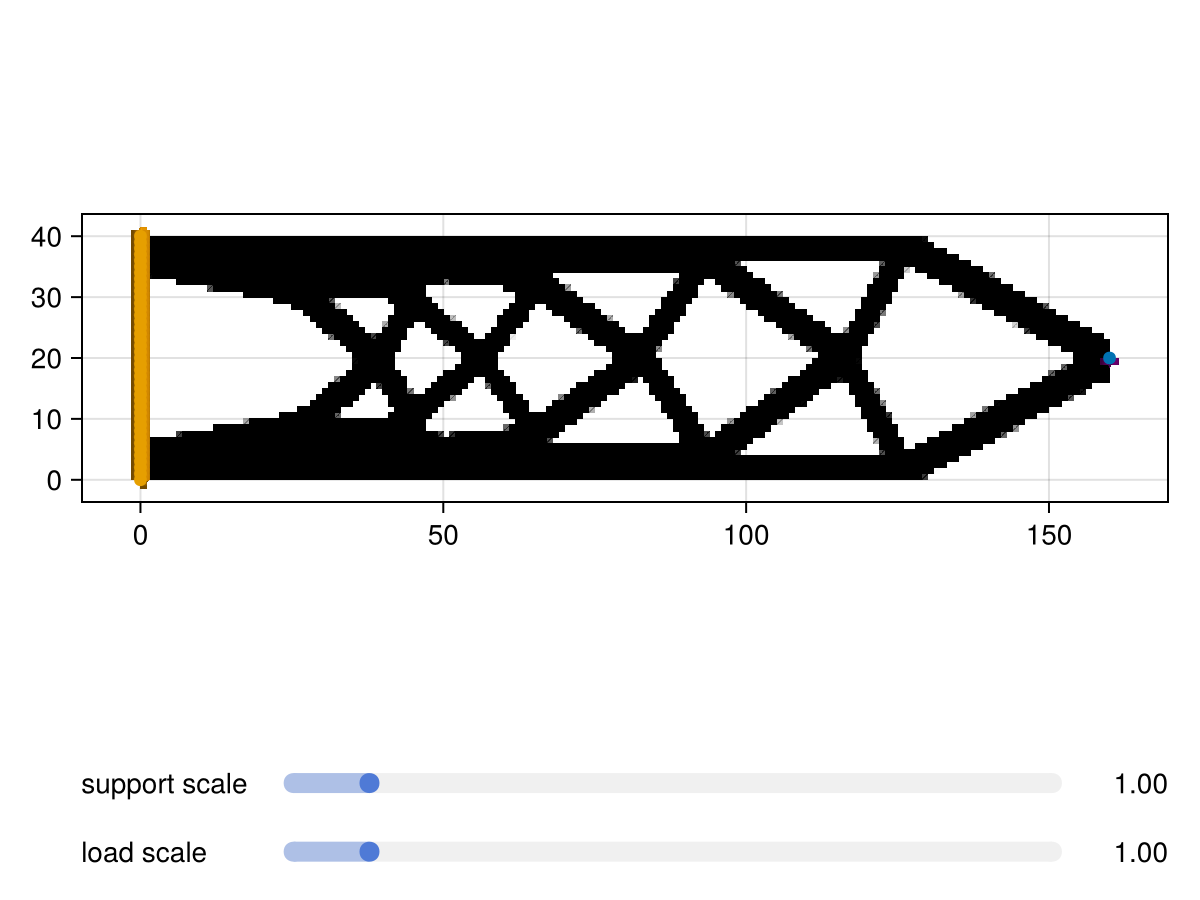

CairoMakie.Screen{IMAGE}


In [7]:
fig = visualize(
    problem;
    topology=x,
    default_exagg_scale=0.07,
    scale_range=10.0,
    vector_linewidth=3,
    vector_arrowsize=0.5,
)
Makie.display(fig)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*